# best neighbor search with classical distance threshold [8, 10, 10, 10] (L=10, N=50)

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from optimization.analyze_codes.decoder_performance_from_state import evaluate_performance_of_state
from optimization.experiments_settings import generate_neighbor_highlight, from_edgelist, load_tanner_graph, parse_edgelist
from optimization.experiments_settings import codes, path_to_initial_codes, textfiles

best_neighbor_search_path = 'optimization/results/best_neighbor_search_4.hdf5'

codes = ['[625,25]', '[1225,65]', '[1600,64]', '[2025,81]']
fn_data = {}

import h5py
import numpy as np

code: [1225,65]
code: [1600,64]
code: [2025,81]
code: [625,25]
code: [625,25], valid neighbor counts per step (excluding initial): [ 6 11 14  9  6  5  6  7  6 10]
Total runtime for [625,25]: 1.0h 32.0m 54.87083911895752s
code: [625,25], min logical error rate among neighbors (excluding initial) per step: [0.00661 0.00582 0.00561 0.00519 0.00542 0.00467 0.00409 0.00385 0.0038
 0.00353]
y: [0.0122  0.00661 0.00582 0.00561 0.00519 0.00542 0.00467 0.00409 0.00385
 0.0038 ]
yerr: [0.00068041 0.00050225 0.00047147 0.00046293 0.00044536 0.00045507
 0.00042257 0.00039558 0.00038384 0.00038135]


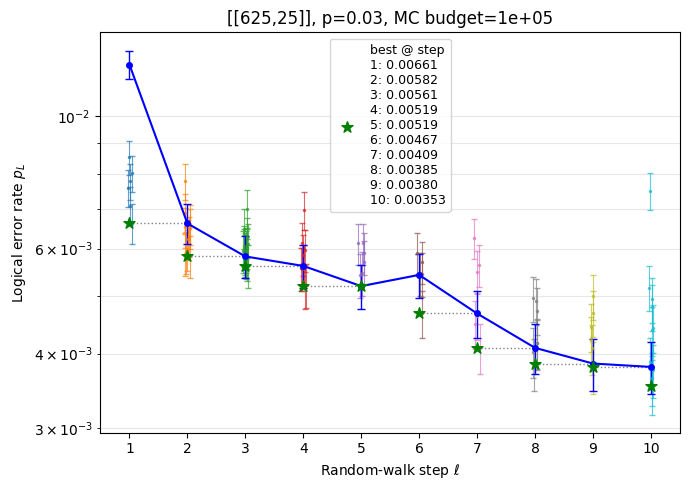

----------------------------------------------------------------------------------------------------
code: [1225,65], valid neighbor counts per step (excluding initial): [0 0 0 0 0 0 0 0 0 0]
Total runtime for [1225,65]: 0.0h 38.0m 26.635061740875244s
code: [1225,65], min logical error rate among neighbors (excluding initial) per step: [nan nan nan nan nan nan nan nan nan nan]
y: [0.02176 0.0139  0.02133 0.02953 0.02728 0.02134 0.02088 0.0199  0.03275
 0.0267 ]
yerr: [0.0009043  0.00072565 0.00089551 0.00104925 0.00100966 0.00089572
 0.00088622 0.00086561 0.00110315 0.00099917]


/var/folders/qm/b1zgl4n51dx4f08pr04pv_k80000gq/T/ipykernel_53020/1693374250.py:65: RuntimeWarning: All-NaN slice encountered
  min_ler_each_step = np.nanmin(np.where(y[:, 1:] > 0, y[:, 1:], np.nan), axis=1)


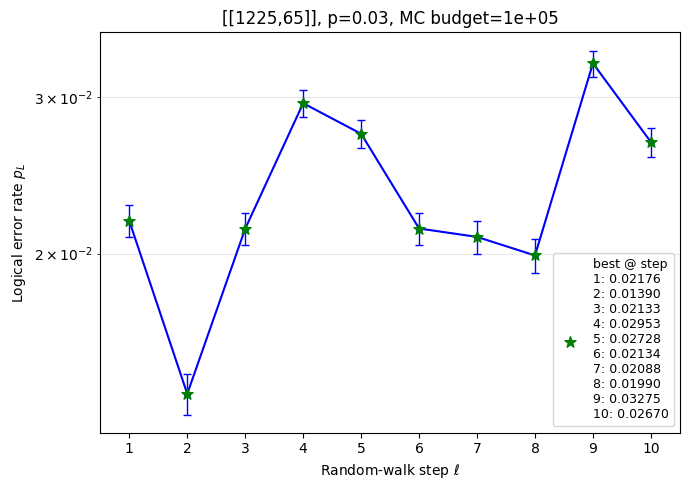

----------------------------------------------------------------------------------------------------
code: [1600,64], valid neighbor counts per step (excluding initial): [ 1 20 20 26 18 13 20 21 20 16]
Total runtime for [1600,64]: 15.0h 50.0m 59.04632306098938s
code: [1600,64], min logical error rate among neighbors (excluding initial) per step: [0.00228 0.00188 0.00165 0.00135 0.00138 0.0015  0.0015  0.00144 0.00163
 0.00186]
y: [0.0125  0.00228 0.00188 0.00165 0.00135 0.00138 0.0015  0.0015  0.00144
 0.00163]
yerr: [0.00068862 0.00029562 0.00026849 0.00025156 0.00022758 0.00023009
 0.00023987 0.00023987 0.00023503 0.00025003]


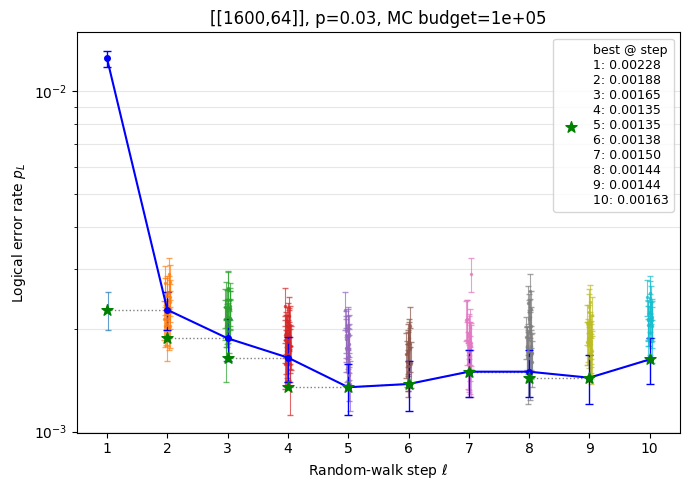

----------------------------------------------------------------------------------------------------
code: [2025,81], valid neighbor counts per step (excluding initial): [34 29 28 29 23 19 19 31 24 22]
Total runtime for [2025,81]: 31.0h 6.0m 29.84446096420288s
code: [2025,81], min logical error rate among neighbors (excluding initial) per step: [0.00133 0.00099 0.00101 0.00094 0.00101 0.00093 0.00097 0.00097 0.00092
 0.00105]
y: [0.00215 0.00133 0.00099 0.00101 0.00094 0.00101 0.00093 0.00097 0.00097
 0.00092]
yerr: [0.00028708 0.00022589 0.00019492 0.00019688 0.00018994 0.00019688
 0.00018893 0.00019294 0.00019294 0.00018791]


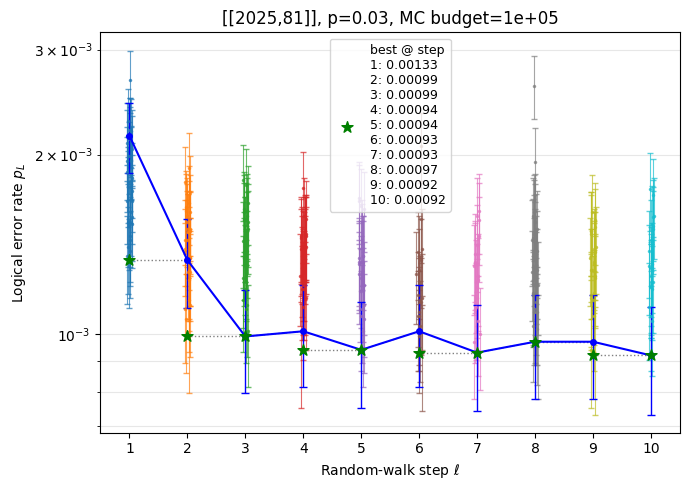

----------------------------------------------------------------------------------------------------


In [84]:
with h5py.File(best_neighbor_search_path, 'r') as f:
    for code, grp in f.items():
        print(f"code: {code}")
        fn_data[code] = {}
        fn_data[code]['N'] = grp.attrs['N']
        fn_data[code]['L'] = grp.attrs['L']
        fn_data[code]['osd_order'] = grp.attrs['osd_order']
        fn_data[code]['ms_scaling_factor'] = grp.attrs['ms_scaling_factor']
        fn_data[code]['MC_budget'] = grp.attrs['MC_budget']
        fn_data[code]['p'] = grp.attrs['p']
        fn_data[code]['total_runtime'] = grp.attrs['total_runtime']
        fn_data[code]['states'] = grp['states'][()].copy()
        fn_data[code]['logical_error_rates'] = grp['logical_error_rates'][()].copy()
        fn_data[code]['stds'] = grp['logical_error_rates_std'][()].copy()
        fn_data[code]['distances_quantum'] = grp['distances_quantum'][()].copy()
        fn_data[code]['distances_Hx'] = grp['distances_Hx'][()].copy()
        fn_data[code]['distances_Hz'] = grp['distances_Hz'][()].copy()
        fn_data[code]['distances_classical'] = grp['distances_classical'][()].copy()
        fn_data[code]['decoding_runtimes'] = grp['decoding_runtimes'][()].copy()

physical_error_rates = [fn_data[code]['p'] for code in codes]

exploration_params = {code: par for code, par in zip(codes, [(fn_data[code]['L'], fn_data[code]['N'])])}

exploration_params = {}

for code in fn_data:
    exploration_params[code] = (fn_data[code]['L'], fn_data[code]['N'])
    fn_data[code]['logical_error_rates'] = fn_data[code]['logical_error_rates'].reshape(exploration_params[code])
    fn_data[code]['stds'] = fn_data[code]['stds'].reshape(exploration_params[code])
    fn_data[code]['distances_quantum'] = fn_data[code]['distances_quantum'].reshape(exploration_params[code])

import matplotlib.pyplot as plt
import numpy as np

for code in codes:

    data = fn_data[code]
    L, N = data['logical_error_rates'].shape  # (steps, neighbors incl. initial)
    x_steps = np.arange(1, L+1)
    y = data['logical_error_rates']           # shape (L, N)
    yerr = 1.96 * data['stds']                # shape (L, N)
    distances_classical = data['distances_classical'].reshape(L, N)  # shape (L, N)

    fig, ax = plt.subplots(figsize=(7, 5))

    # Neighbor cloud per step (columns 1..N-1) with slight horizontal jitter
    # count how many valid (non-NaN, non-inf) neighbors we have per step
    valid_counts = np.sum((y[:, 1:] > 0), axis=1)
    print(f"code: {code}, valid neighbor counts per step (excluding initial): {valid_counts}")
    print(f"Total runtime for {code}: {data['total_runtime'] // 3600}h {data['total_runtime'] % 3600 // 60}m {data['total_runtime'] % 60}s")
    rng = np.random.default_rng(0)
    for ell in range(L):
        x_base = x_steps[ell]
        # draw neighbors at this step with small jitter
        nn = y[ell, 1:]
        nne = yerr[ell, 1:]
        jitter = (rng.uniform(-0.05, 0.05, size=nn.shape))
        xj = x_base + jitter
        # plot neighbor points
        ax.errorbar(
            xj, nn, yerr=nne,
            fmt='.', markersize=3, elinewidth=0.8, capsize=2, alpha=0.7, label=None
        )
    min_ler_each_step = np.nanmin(np.where(y[:, 1:] > 0, y[:, 1:], np.nan), axis=1)
    print(f"code: {code}, min logical error rate among neighbors (excluding initial) per step: {min_ler_each_step}")
    print(f"y: {y[:, 0]}")
    print(f"yerr: {yerr[:, 0]}")
    # Initial state trace (column 0)
    ax.errorbar(
        x_steps, y[:, 0], yerr=yerr[:, 0],
        fmt='o-', color='b', markersize=4, elinewidth=1, capsize=3
    )

    # Per-step best (min across all N at that step)
    # exclude zeros by turning them into +inf for the min search
    y_pos = np.where(y > 0, y, np.inf)            # shape (L, N)

    step_best_idx  = np.argmin(y_pos, axis=1)     # argmin among only positives

    step_best_cost = y_pos[np.arange(L), step_best_idx]

    step_best_distance = distances_classical[np.arange(L), step_best_idx]


    step_best_cost_string = "\n".join([f"{idx+1}: {v:.5f}" for idx, v in enumerate(step_best_cost)])
    ax.scatter(x_steps, step_best_cost, marker='*', color='g', s=70, label=f'best @ step\n{step_best_cost_string}', zorder=3)

    # Optional dashed connector from best@step l to initial@(l+1)
    for ell in range(L-1):
        ax.plot(
            [x_steps[ell], x_steps[ell+1]],
            [step_best_cost[ell], y[ell+1, 0]],
            linestyle=':', linewidth=1, color='gray', alpha=1
        )

    # Formatting
    ax.set_title(f'[{code}], p={data["p"]}, MC budget={data["MC_budget"]:.0e}')
    ax.set_xlabel('Random-walk step $\\ell$')
    ax.set_ylabel('Logical error rate $p_L$')
    ax.set_yscale('log')
    ax.grid(True, which='both', axis='y', alpha=0.3)

    # ticks: show integer steps (thin out if L is large)
    if L <= 15:
        ax.set_xticks(x_steps)
    else:
        ax.set_xticks(np.linspace(1, L, 10, dtype=int))

    ax.legend(loc='best', fontsize=9)
    plt.tight_layout()
    plt.show()

    print("-"*100)

In [38]:
best_idx = np.argmin(step_best_cost) * N + step_best_idx[np.argmin(step_best_cost)]
print(f"step_best_cost: {step_best_cost}, step_best_idx[np.argmin(step_best_cost)]: {step_best_idx[np.argmin(step_best_cost)]}, best_idx: {best_idx}, np.argmin(step_best_cost): {np.argmin(step_best_cost)}")
best_state_edge_list = data['states'][best_idx]
best_state = from_edgelist(best_state_edge_list)

MC_budget = int(1e6)
p = data['p']

best_code_result = evaluate_performance_of_state(state=best_state, p_vals=[p], MC_budget=MC_budget, distance_threshold=8, canskip=False)

step_best_cost: [0.00661 0.00582 0.00561 0.00519 0.00542 0.00467 0.00409 0.00385 0.0038
 0.00353], step_best_idx[np.argmin(step_best_cost)]: 45, best_idx: 495, np.argmin(step_best_cost): 9
Rank of H: 15 out of (15, 20)
Time taken to compute exact code distance: 0.0004532337188720703 seconds
H Classical Code parameters: [20, 5, 8]
H is full rank.
H^T Classical Code parameters: [15, 0, inf]
Time taken to compute exact quantum code distances: 0.0033538341522216797 seconds
H_X Code parameters: nx=625, d_Hx=625
H_Z Code parameters: nz=625, d_Hz=625
Quantum Code parameters: [[625, 25, 625]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ldpc/code_util/code_util.py:164: UserWarning: This function has exponential complexity. Not recommended for large pcms. Use the                            'ldpc.code_util.estimate_code_distance' function instead.
  warnings.warn(


Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Random walk finished in 13.0m 56.25s with 3914 failures out of 1000000 runs.
Logical error rate for Random walk: 0.003914 ± 0.0000624 (stderr)
Logical error rate for p=0.03: 0.003914


# logical error rate of the best state from random walk (erasure channel) with MC=1e6

In [41]:
random_walk_result_path = "./optimization/results/exploration.hdf5"
codes = ['[625,25]', '[1225,65]', '[1600,64]', '[2025,81]']
C = 0  # index into codes list
with h5py.File(random_walk_result_path, 'r') as f:
    best_state_edge_list, _ = min(((s, v) for s, v in zip(f[codes[C]]['states'], f[codes[C]]['values'])), key=lambda x: x[1])
    index_of_min = np.argmin(f[codes[C]]['values'])
    print(f"Minimum logical error rate found in state {index_of_min} with value {f[codes[C]]['values'][index_of_min][0]}")
    best_state = from_edgelist(best_state_edge_list)

MC_budget = int(1e6)
p = data['p']
best_code_result = evaluate_performance_of_state(state=best_state, p_vals=[p], MC_budget=MC_budget, distance_threshold=8, canskip=False)

Minimum logical error rate found in state 1871 with value 0.0091
Rank of H: 15 out of (15, 20)
Time taken to compute exact code distance: 0.0002949237823486328 seconds
H Classical Code parameters: [20, 5, 8]
H is full rank.
H^T Classical Code parameters: [15, 0, inf]
Time taken to compute exact quantum code distances: 0.0035021305084228516 seconds
H_X Code parameters: nx=625, d_Hx=625
H_Z Code parameters: nz=625, d_Hz=625
Quantum Code parameters: [[625, 25, 625]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ldpc/code_util/code_util.py:164: UserWarning: This function has exponential complexity. Not recommended for large pcms. Use the                            'ldpc.code_util.estimate_code_distance' function instead.
  warnings.warn(


Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Random walk finished in 13.0m 37.29s with 4475 failures out of 1000000 runs.
Logical error rate for Random walk: 0.004475 ± 0.0000667 (stderr)
Logical error rate for p=0.03: 0.004475


In [36]:
import numpy as np
import h5py
import scipy.sparse as sp
from optimization.experiments_settings import from_edgelist, tanner_graph_to_parity_check_matrix
from optimization.analyze_codes.decoder_performance_from_state import compute_classical_code_parameters, evaluate_performance_of_state

random_walk_result_path = "./optimization/results/exploration.hdf5"
codes = ['[1225,65]']
MC_budget = int(1e5)
p = 0.03

for C in range(len(codes)):
    with h5py.File(random_walk_result_path, 'r') as f:
        grp = f[codes[C]]

        # find argmin
        idx_min = int(np.argmin(grp['values']))
        val_min = float(np.array(grp['values'][idx_min]).ravel()[0])
        print(f"Minimum logical error rate found in state {idx_min} with value {val_min}")

        # get the raw edge data for that state
        raw = np.array(grp['states'][idx_min])

        # ensure shape is (E, 2)
        if raw.ndim == 1:
            if raw.size % 2 != 0:
                raise ValueError(f"Malformed edge list for {codes[C]} at state {idx_min}: odd length {raw.size}")
            edgelist = raw.reshape(-1, 2)
        else:
            edgelist = raw

        # rebuild the Tanner graph, then get H
        G = from_edgelist(edgelist.astype(np.int64))
        H = tanner_graph_to_parity_check_matrix(G)           # dense bool array
        H_csr = sp.csr_matrix(H, dtype=np.uint8)

        # compute [n, k, d]
        n, k, d = compute_classical_code_parameters(H_csr)
        print(f"Classical code parameters: [n={n}, k={k}, d={d}]")
        # d_lower_bound = compute_hgp_code_distance_lower_bound(H_csr, H_csr.T)
        # print(f"Lower bound on HGP code distance: {d_lower_bound}")
        # print("-"*100)
        best_state = G

        best_code_result = evaluate_performance_of_state(state=best_state, p_vals=[p], MC_budget=MC_budget, distance_threshold=10, canskip=False)

        print(f"Best code result for {codes[C]}: {best_code_result}")
        print("="*100)


Minimum logical error rate found in state 410 with value 0.0005
Classical code parameters: [n=28, k=7, d=10]
Rank of H: 21 out of (21, 28)
H Classical Code parameters: [28, 7, 10]
H is full rank.
H^T Classical Code parameters: [21, 0, inf]
H_X Code parameters: nx=1225, d_Hx=10
H_Z Code parameters: nz=1225, d_Hz=6
Quantum Code parameters: [[1225, 49, 6]]
Hx, Hz, Lx, Lz: (588, 1225), (588, 1225), (49, 1225), (49, 1225)
BP max iterations: 122, OSD order: 2, MS scaling factor: 0.625
Decoder Random walk finished in 4.0m 10.73s with 212 failures out of 100000 runs.
Logical error rate for Random walk: 0.00212 ± 0.0001454 (stderr)
Logical error rate for p=0.03: 0.00212
Best code result for [1225,65]: {'logical_error_rates': [0.00212], 'stderrs': [0.00014544850481416278], 'n_classical': 28, 'k_classical': 7, 'd_classical': 10, 'n_T_classical': 21, 'k_T_classical': 0, 'd_T_classical': inf, 'rank_H': 21, 'n_quantum': 1225, 'k_quantum': 49, 'd_quantum': 6, 'd_Hx': 10, 'd_Hz': 6, 'runtimes': [250.7

In [48]:
import numpy as np
import h5py
import scipy.sparse as sp
from optimization.experiments_settings import from_edgelist, tanner_graph_to_parity_check_matrix
from optimization.analyze_codes.decoder_performance_from_state import compute_classical_code_parameters, evaluate_performance_of_state

random_walk_result_path = "./optimization/results/exploration.hdf5"
codes = ['[625,25]', '[1225,65]', '[1600,64]', '[2025,81]']
MC_budget = int(1e6)
p = 0.03

for C in range(1, len(codes)):
    with h5py.File(random_walk_result_path, 'r') as f:
        grp = f[codes[C]]

        # find argmin
        idx_min = int(np.argmin(grp['values']))
        val_min = float(np.array(grp['values'][idx_min]).ravel()[0])
        print(f"Minimum logical error rate found in state {idx_min} with value {val_min}")

        # get the raw edge data for that state
        raw = np.array(grp['states'][idx_min])

        # ensure shape is (E, 2)
        if raw.ndim == 1:
            if raw.size % 2 != 0:
                raise ValueError(f"Malformed edge list for {codes[C]} at state {idx_min}: odd length {raw.size}")
            edgelist = raw.reshape(-1, 2)
        else:
            edgelist = raw

        # rebuild the Tanner graph, then get H
        G = from_edgelist(edgelist.astype(np.int64))
        H = tanner_graph_to_parity_check_matrix(G)           # dense bool array
        H_csr = sp.csr_matrix(H, dtype=np.uint8)

        # compute [n, k, d]
        n, k, d = compute_classical_code_parameters(H_csr)
        print(f"Classical code parameters: [n={n}, k={k}, d={d}]")
        # d_lower_bound = compute_hgp_code_distance_lower_bound(H_csr, H_csr.T)
        # print(f"Lower bound on HGP code distance: {d_lower_bound}")
        # print("-"*100)
        best_state = G

        best_code_result = evaluate_performance_of_state(state=best_state, p_vals=[p], MC_budget=MC_budget, distance_threshold=10, canskip=False)

        print(f"Best code result for {codes[C]}: {best_code_result}")
        print("="*100)


Minimum logical error rate found in state 410 with value 0.0005
Classical code parameters: [n=28, k=7, d=10]
Rank of H: 21 out of (21, 28)
H Classical Code parameters: [28, 7, 10]
H is full rank.
H^T Classical Code parameters: [21, 0, inf]
H_X Code parameters: nx=1225, d_Hx=10
H_Z Code parameters: nz=1225, d_Hz=6
Quantum Code parameters: [[1225, 49, 6]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ldpc/code_util/code_util.py:164: UserWarning: This function has exponential complexity. Not recommended for large pcms. Use the                            'ldpc.code_util.estimate_code_distance' function instead.
  warnings.warn(


Hx, Hz, Lx, Lz: (588, 1225), (588, 1225), (49, 1225), (49, 1225)
BP max iterations: 122, OSD order: 2, MS scaling factor: 0.625
Decoder Random walk finished in 41.0m 14.92s with 1986 failures out of 1000000 runs.
Logical error rate for Random walk: 0.001986 ± 0.0000445 (stderr)
Logical error rate for p=0.03: 0.001986
Best code result for [1225,65]: {'logical_error_rates': [0.001986], 'stderrs': [4.4520307569218196e-05], 'n_classical': 28, 'k_classical': 7, 'd_classical': 10, 'n_T_classical': 21, 'k_T_classical': 0, 'd_T_classical': inf, 'rank_H': 21, 'n_quantum': 1225, 'k_quantum': 49, 'd_quantum': 6, 'd_Hx': 10, 'd_Hz': 6, 'runtimes': [2474.9151878356934], 'skipped': False}
Minimum logical error rate found in state 37 with value 0.0012
Classical code parameters: [n=32, k=8, d=10]
Rank of H: 24 out of (24, 32)
H Classical Code parameters: [32, 8, 10]
H is full rank.
H^T Classical Code parameters: [24, 0, inf]
H_X Code parameters: nx=1600, d_Hx=11
H_Z Code parameters: nz=1600, d_Hz=10
Q

In [69]:
simulated_annealing_result_path = "./optimization/results/simulated_annealing_beta7.hdf5"
codes = ['[625,25]', '[1225,65]', '[1600,64]', '[2025,81]']
C = 0  # index into codes list
with h5py.File(simulated_annealing_result_path, 'r') as f:
    min_cost = min(v for v in f[codes[C]]['logical_error_rates'] if v > 0)
    index_of_min = np.argmin(f[codes[C]]['logical_error_rates'])
    best_state_edge_list = f[codes[C]]['best_state'][()]
    print(f"Minimum logical error rate found in state {index_of_min} with value {min_cost}")
    print(f"best state edge list: {best_state_edge_list}")
    best_state = from_edgelist(best_state_edge_list)

MC_budget = int(1e6)
p = data['p']
best_code_result = evaluate_performance_of_state(state=best_state, p_vals=[p], MC_budget=MC_budget, distance_threshold=8, canskip=False)

Minimum logical error rate found in state 1995 with value 0.00378
best state edge list: [[ 0 23  0 25  0 30  0 32  1 15  1 22  1 26  1 34  2 20  2 22  2 27  2 31
   2 31  3 18  3 28  3 33  3 34  4 17  4 19  4 27  4 33  5 15  5 18  5 30
   5 34  6 15  6 21  6 27  6 29  7 20  7 22  7 23  7 26  8 17  8 17  8 25
   8 29  9 16  9 18  9 26  9 32 10 21 10 29 10 30 10 32 11 16 11 19 11 28
  11 31 12 19 12 20 12 21 12 23 13 16 13 24 13 24 13 33 14 24 14 25 14 28]]
Rank of H: 15 out of (15, 20)
Time taken to compute exact code distance: 0.00034689903259277344 seconds
H Classical Code parameters: [20, 5, 8]
H is full rank.
H^T Classical Code parameters: [15, 0, inf]
Time taken to compute exact quantum code distances: 0.004460811614990234 seconds
H_X Code parameters: nx=625, d_Hx=625
H_Z Code parameters: nz=625, d_Hz=625
Quantum Code parameters: [[625, 25, 625]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ldpc/code_util/code_util.py:164: UserWarning: This function has exponential complexity. Not recommended for large pcms. Use the                            'ldpc.code_util.estimate_code_distance' function instead.
  warnings.warn(


Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Random walk finished in 12.0m 56.10s with 3855 failures out of 1000000 runs.
Logical error rate for Random walk: 0.003855 ± 0.0000620 (stderr)
Logical error rate for p=0.03: 0.003855


## best code from greedy [[625,25]]

In [44]:
simulated_annealing_result_path = "./optimization/results/greedy_exploration_bpmaxiter_62_run4.hdf5"
codes = ['[625,25]', '[1225,65]', '[1600,64]', '[2025,81]']
C = 0  # index into codes list
with h5py.File(simulated_annealing_result_path, 'r') as f:
    min_cost = min(v for v in f[codes[C]]['logical_error_rates'] if v > 0)
    index_of_min = np.argmin(f[codes[C]]['logical_error_rates'])
    best_state_edge_list = f[codes[C]]['best_state'][()]
    print(f"Minimum logical error rate found in state {index_of_min} with value {min_cost}")
    print(f"best state edge list: {best_state_edge_list}")
    best_state = from_edgelist(best_state_edge_list)

    total_runtime_seconds = f[codes[C]].attrs['runtime']
    print(f"Total runtime for greedy on {codes[C]}: {total_runtime_seconds // 3600}h {total_runtime_seconds % 3600 // 60}m {total_runtime_seconds % 60}s")

MC_budget = int(1e6)
p = 0.03
best_code_result = evaluate_performance_of_state(state=best_state, p_vals=[p], MC_budget=MC_budget, distance_threshold=8, canskip=False)

Minimum logical error rate found in state 31 with value [0.00434]
best state edge list: [[ 0 15  0 20  0 24  0 24  1 15  1 21  1 25  1 25  2 15  2 22  2 26  2 32
   2 34  3 16  3 20  3 26  3 31  4 16  4 22  4 25  4 30  5 16  5 23  5 27
   5 32  6 17  6 27  6 31  6 33  7 17  7 22  7 28  7 31  8 17  8 23  8 29
   8 30  9 18  9 21  9 27  9 32 10 18 10 23 10 26 10 33 11 18 11 29 11 30
  11 34 12 19 12 21 12 28 12 34 13 19 13 24 13 28 13 33 14 19 14 20 14 29]]
Total runtime for greedy on [625,25]: 0.0h 57.0m 19.29941701889038s
Rank of H: 15 out of (15, 20)
H Classical Code parameters: [20, 5, 7]
H is full rank.
H^T Classical Code parameters: [15, 0, inf]
H_X Code parameters: nx=625, d_Hx=6
H_Z Code parameters: nz=625, d_Hz=7
Quantum Code parameters: [[625, 25, 6]]
Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Random walk finished in 10.0m 28.73s with 4789 failures out of 1000000 runs.
Logical error rate for

# [[625, 25]] best neighbor search with classical distance threshold 8 (L=15, N=50)

code: [625,25]
code: [625,25], valid neighbor counts per step (excluding initial): [ 2 13  9  8 11  9 14 10  4  9 11  8 11  7  4]
Total runtime for [625,25]: 3.0h 2.0m 59.61686301231384s
code: [625,25], min logical error rate among neighbors (excluding initial) per step: [0.00707 0.00509 0.00513 0.00518 0.00394 0.00416 0.00333 0.0033  0.00368
 0.00339 0.00348 0.00366 0.00347 0.00333 0.00346]
y: [0.01216 0.00707 0.00509 0.00513 0.00518 0.00394 0.00416 0.00333 0.0033
 0.00368 0.00339 0.00348 0.00366 0.00347 0.00333]
yerr: [0.00067931 0.00051931 0.00044107 0.00044279 0.00044493 0.00038828
 0.00039893 0.00035707 0.00035547 0.0003753  0.00036026 0.000365
 0.00037429 0.00036448 0.00035707]


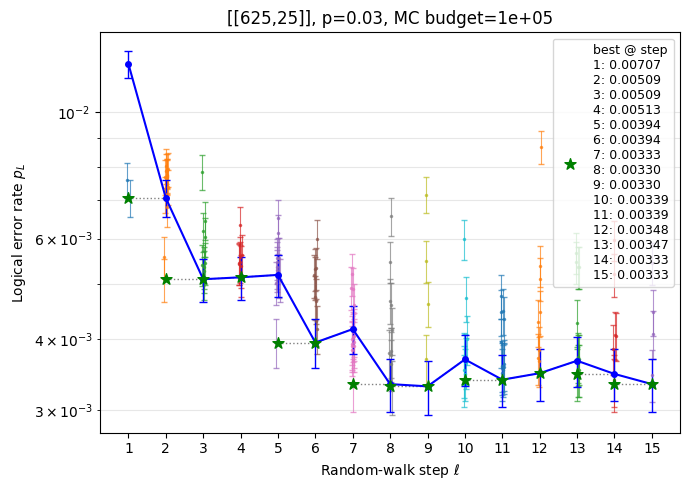

----------------------------------------------------------------------------------------------------


In [76]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from optimization.analyze_codes.decoder_performance_from_state import evaluate_performance_of_state
from optimization.experiments_settings import generate_neighbor_highlight, from_edgelist, load_tanner_graph, parse_edgelist
from optimization.experiments_settings import codes, path_to_initial_codes, textfiles

best_neighbor_search_path = './optimization/results/best_neighbor_search_5.hdf5'

codes = ['[625,25]']
fn_data = {}

import h5py
import numpy as np

with h5py.File(best_neighbor_search_path, 'r') as f:
    for code, grp in f.items():
        print(f"code: {code}")
        fn_data[code] = {}
        fn_data[code]['N'] = grp.attrs['N']
        fn_data[code]['L'] = grp.attrs['L']
        fn_data[code]['osd_order'] = grp.attrs['osd_order']
        fn_data[code]['ms_scaling_factor'] = grp.attrs['ms_scaling_factor']
        fn_data[code]['MC_budget'] = grp.attrs['MC_budget']
        fn_data[code]['p'] = grp.attrs['p']
        fn_data[code]['total_runtime'] = grp.attrs['total_runtime']
        fn_data[code]['states'] = grp['states'][()].copy()
        fn_data[code]['logical_error_rates'] = grp['logical_error_rates'][()].copy()
        fn_data[code]['stds'] = grp['logical_error_rates_std'][()].copy()
        fn_data[code]['distances_quantum'] = grp['distances_quantum'][()].copy()
        fn_data[code]['distances_Hx'] = grp['distances_Hx'][()].copy()
        fn_data[code]['distances_Hz'] = grp['distances_Hz'][()].copy()
        fn_data[code]['distances_classical'] = grp['distances_classical'][()].copy()
        fn_data[code]['decoding_runtimes'] = grp['decoding_runtimes'][()].copy()

physical_error_rates = [fn_data[code]['p'] for code in codes]

exploration_params = {code: par for code, par in zip(codes, [(fn_data[code]['L'], fn_data[code]['N'])])}

exploration_params = {}

for code in fn_data:
    exploration_params[code] = (fn_data[code]['L'], fn_data[code]['N'])
    fn_data[code]['logical_error_rates'] = fn_data[code]['logical_error_rates'].reshape(exploration_params[code])
    fn_data[code]['stds'] = fn_data[code]['stds'].reshape(exploration_params[code])
    fn_data[code]['distances_quantum'] = fn_data[code]['distances_quantum'].reshape(exploration_params[code])

import matplotlib.pyplot as plt
import numpy as np

for code in codes:

    data = fn_data[code]

    L, N = data['logical_error_rates'].shape  # (steps, neighbors incl. initial)
    x_steps = np.arange(1, L+1)
    y = data['logical_error_rates']           # shape (L, N)
    yerr = 1.96 * data['stds']                # shape (L, N)
    distances_classical = data['distances_classical'].reshape(L, N)  # shape (L, N)

    fig, ax = plt.subplots(figsize=(7, 5))

    # Neighbor cloud per step (columns 1..N-1) with slight horizontal jitter
    # count how many valid (non-NaN, non-inf) neighbors we have per step
    valid_counts = np.sum((y[:, 1:] > 0), axis=1)
    print(f"code: {code}, valid neighbor counts per step (excluding initial): {valid_counts}")
    print(f"Total runtime for {code}: {data['total_runtime'] // 3600}h {data['total_runtime'] % 3600 // 60}m {data['total_runtime'] % 60}s")
    rng = np.random.default_rng(0)
    for ell in range(L):
        x_base = x_steps[ell]
        # draw neighbors at this step with small jitter
        nn = y[ell, 1:]
        nne = yerr[ell, 1:]
        jitter = (rng.uniform(-0.05, 0.05, size=nn.shape))
        xj = x_base + jitter
        # plot neighbor points
        ax.errorbar(
            xj, nn, yerr=nne,
            fmt='.', markersize=3, elinewidth=0.8, capsize=2, alpha=0.7, label=None
        )
    min_ler_each_step = np.nanmin(np.where(y[:, 1:] > 0, y[:, 1:], np.nan), axis=1)
    print(f"code: {code}, min logical error rate among neighbors (excluding initial) per step: {min_ler_each_step}")
    print(f"y: {y[:, 0]}")
    print(f"yerr: {yerr[:, 0]}")
    # Initial state trace (column 0)
    ax.errorbar(
        x_steps, y[:, 0], yerr=yerr[:, 0],
        fmt='o-', color='b', markersize=4, elinewidth=1, capsize=3
    )

    # Per-step best (min across all N at that step)
    # exclude zeros by turning them into +inf for the min search
    y_pos = np.where(y > 0, y, np.inf)            # shape (L, N)

    step_best_idx  = np.argmin(y_pos, axis=1)     # argmin among only positives

    step_best_cost = y_pos[np.arange(L), step_best_idx]

    step_best_distance = distances_classical[np.arange(L), step_best_idx]


    step_best_cost_string = "\n".join([f"{idx+1}: {v:.5f}" for idx, v in enumerate(step_best_cost)])
    ax.scatter(x_steps, step_best_cost, marker='*', color='g', s=70, label=f'best @ step\n{step_best_cost_string}', zorder=3)

    # Optional dashed connector from best@step l to initial@(l+1)
    for ell in range(L-1):
        ax.plot(
            [x_steps[ell], x_steps[ell+1]],
            [step_best_cost[ell], y[ell+1, 0]],
            linestyle=':', linewidth=1, color='gray', alpha=1
        )

    # Formatting
    ax.set_title(f'[{code}], p={data["p"]}, MC budget={data["MC_budget"]:.0e}')
    ax.set_xlabel('Random-walk step $\\ell$')
    ax.set_ylabel('Logical error rate $p_L$')
    ax.set_yscale('log')
    ax.grid(True, which='both', axis='y', alpha=0.3)

    # ticks: show integer steps (thin out if L is large)
    if L <= 15:
        ax.set_xticks(x_steps)
    else:
        ax.set_xticks(np.linspace(1, L, 10, dtype=int))

    ax.legend(loc='best', fontsize=9)
    plt.tight_layout()
    plt.show()

    print("-"*100)

In [77]:
best_idx = np.argmin(step_best_cost) * N + step_best_idx[np.argmin(step_best_cost)]
print(f"step_best_cost: {step_best_cost}, step_best_idx[np.argmin(step_best_cost)]: {step_best_idx[np.argmin(step_best_cost)]}, best_idx: {best_idx}, np.argmin(step_best_cost): {np.argmin(step_best_cost)}")
best_state_edge_list = data['states'][best_idx]
best_state = from_edgelist(best_state_edge_list)

MC_budget = int(1e6)
p = data['p']

best_code_result = evaluate_performance_of_state(state=best_state, p_vals=[p], MC_budget=MC_budget, distance_threshold=8, canskip=False)

step_best_cost: [0.00707 0.00509 0.00509 0.00513 0.00394 0.00394 0.00333 0.0033  0.0033
 0.00339 0.00339 0.00348 0.00347 0.00333 0.00333], step_best_idx[np.argmin(step_best_cost)]: 7, best_idx: 357, np.argmin(step_best_cost): 7
Rank of H: 15 out of (15, 20)
Time taken to compute exact code distance: 0.00016689300537109375 seconds
H Classical Code parameters: [20, 5, 8]
H is full rank.
H^T Classical Code parameters: [15, 0, inf]
Time taken to compute exact quantum code distances: 0.003299236297607422 seconds
H_X Code parameters: nx=625, d_Hx=625
H_Z Code parameters: nz=625, d_Hz=625
Quantum Code parameters: [[625, 25, 625]]
Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Random walk finished in 14.0m 26.95s with 3659 failures out of 1000000 runs.
Logical error rate for Random walk: 0.003659 ± 0.0000604 (stderr)
Logical error rate for p=0.03: 0.003659


# best code from Simulated Annealing result (from paper)

In [72]:
simulated_annealing_result_path = "./optimization/results/sim_ann_deltalog.hdf5"
codes = ['[625,25]', '[1225,65]', '[1600,64]', '[2025,81]']
best_beta = ['beta=4', 'beta=10', 'beta=10', 'beta=1']
MC_budgets = [int(1e6), int(1e5), int(1e5), int(1e5)]
p = 0.03
with h5py.File(simulated_annealing_result_path, 'r') as f:
    for C in range(len(codes)):
        min_cost = min(v for v in f[codes[C]][best_beta[C]]['cost'] if v > 0)
        index_of_min = np.argmin(f[codes[C]][best_beta[C]]['cost'])
        best_state_edge_list = f[codes[C]][best_beta[C]]['theta'][index_of_min]
        print("-"*100)
        print(f"Code: {codes[C]}, Beta setting: {best_beta[C]}")
        print(f"Minimum logical error rate found in state {index_of_min} with value {min_cost}")
        print(f"best state edge list: {best_state_edge_list}")
        best_state = from_edgelist(best_state_edge_list)
        best_code_result = evaluate_performance_of_state(state=best_state, p_vals=[p], MC_budget=MC_budgets[C], distance_threshold=8, canskip=False)
        print(f"Best code result for {codes[C]}: {best_code_result}")




----------------------------------------------------------------------------------------------------
Code: [625,25], Beta setting: beta=4
Minimum logical error rate found in state 759 with value [0.0065]
best state edge list: [ 0 19  0 23  0 30  0 32  1 18  1 27  1 28  1 30  2 24  2 27  2 28  2 34
  2 34  3 16  3 17  3 18  3 34  4 15  4 15  4 21  4 28  5 23  5 24  5 25
  5 32  6 16  6 22  6 26  6 32  7 15  7 20  7 23  7 25  8 17  8 19  8 22
  8 30  9 20  9 27  9 31  9 33 10 17 10 18 10 19 10 33 11 21 11 24 11 29
 11 31 12 25 12 29 12 29 12 31 13 21 13 26 13 26 13 33 14 16 14 20 14 22]
Rank of H: 15 out of (15, 20)
H Classical Code parameters: [20, 5, 8]
H is full rank.
H^T Classical Code parameters: [15, 0, inf]
H_X Code parameters: nx=625, d_Hx=5
H_Z Code parameters: nz=625, d_Hz=6
Quantum Code parameters: [[625, 25, 5]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ldpc/code_util/code_util.py:164: UserWarning: This function has exponential complexity. Not recommended for large pcms. Use the                            'ldpc.code_util.estimate_code_distance' function instead.
  warnings.warn(


Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Random walk finished in 15.0m 7.17s with 3467 failures out of 1000000 runs.
Logical error rate for Random walk: 0.003467 ± 0.0000588 (stderr)
Logical error rate for p=0.03: 0.003467
Best code result for [625,25]: {'logical_error_rates': [0.003467], 'stderrs': [5.87791065429152e-05], 'n_classical': 20, 'k_classical': 5, 'd_classical': 8, 'n_T_classical': 15, 'k_T_classical': 0, 'd_T_classical': inf, 'rank_H': 15, 'n_quantum': 625, 'k_quantum': 25, 'd_quantum': 5, 'd_Hx': 5, 'd_Hz': 6, 'runtimes': [907.1722402572632], 'skipped': False}
----------------------------------------------------------------------------------------------------
Code: [1225,65], Beta setting: beta=10
Minimum logical error rate found in state 743 with value [0.0001]
best state edge list: [ 0 29  0 30  0 33  0 36  0 44  1 26  1 34  1 39  1 48  2 35  2 39  2 40
  2 43  3 24  3 28  3 31  3 

# best neighbor search with early stop and lookahead

code: [625,25]
Total runtime for [[625,25]]: 1.0h 50.0m 12.369638919830322s
Physical error rate p: 0.03, MC budget: 1e+05
Number of steps L: 10, neighbors per step (incl. initial) N: 50
OSD order: 2, MS scaling factor: 0.625
logical error rate of initial state: 0.01254 ± 0.00035189305518470076
Best logical error rate found at step 234:
Best logical error rate found: 0.00332 ± 0.00018190686325993585
Initial state classical code parameters: [20, 5, 6]
Best state classical code parameters found: [20, 5, 8]
Number of valid neighbors per step (excluding initial): [6, 10, 8, 10, 10, 10, 10, 5, 10, 7]
----------------------------------------------------------------------------------------------------


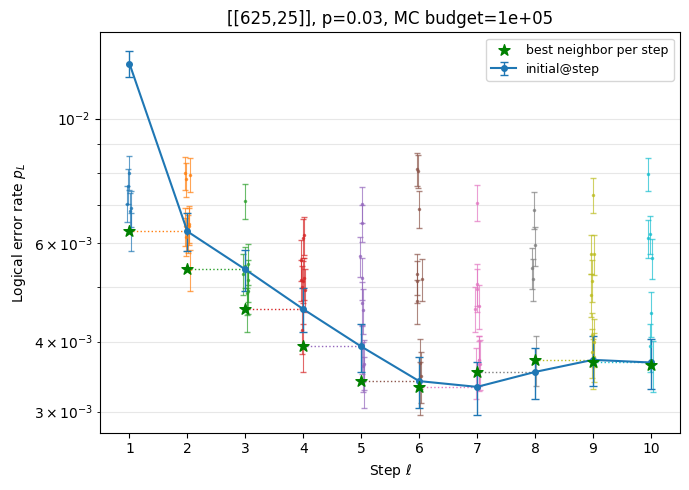

In [118]:
import matplotlib.pyplot as plt
import numpy as np
import h5py

best_neighbor_search_path = './optimization/results/best_neighbor_search_early_stop_lookahead.hdf5'

with h5py.File(best_neighbor_search_path, 'r') as f:
    for code, grp in f.items():
        print(f"code: {code}")
        # Streams (1D each, same length)
        y  = grp['logical_error_rates'][()]          # shape (T,)
        ye = grp['logical_error_rates_std'][()]      # shape (T,)
        distances_classical = grp['distances_classical'][()]  # shape (T,)
        k_classical = grp['k_classical'][()]            # shape (T,)
        n_classical = grp['n_classical'][()]            # shape (T,)

        step_summ = grp['step_summaries'][()]        # shape (S, 4) -> [start, scanned, valid, chosen_row]
        S = step_summ.shape[0]

        y_pos = np.where(y > 0, y, np.inf)

        print(f"Total runtime for [{code}]: {grp.attrs['total_runtime'] // 3600}h {grp.attrs['total_runtime'] % 3600 // 60}m {grp.attrs['total_runtime'] % 60}s")
        print(f"Physical error rate p: {grp.attrs['p']}, MC budget: {grp.attrs['MC_budget']:.0e}")
        print(f"Number of steps L: {grp.attrs['L']}, neighbors per step (incl. initial) N: {grp.attrs['N']}")
        print(f"OSD order: {grp.attrs['osd_order']}, MS scaling factor: {grp.attrs['ms_scaling_factor']}")
        
        print(f"logical error rate of initial state: {y[0]} ± {ye[0]}")
        print(f"Best logical error rate found at step {np.argmin(y_pos)}:")
        print(f"Best logical error rate found: {np.min(y_pos)} ± {ye[np.argmin(y_pos)]}")
        print(f"Initial state classical code parameters: [{n_classical[0]}, {k_classical[0]}, {int(distances_classical[0])}]")
        print(f"Best state classical code parameters found: [{n_classical[np.argmin(y_pos)]}, {k_classical[np.argmin(y_pos)]}, {int(distances_classical[np.argmin(y_pos)])}]")

        print(f"Number of valid neighbors per step (excluding initial): {[int(step_summ[s,2]) for s in range(S)]}")
        print("-"*100)

        # Recover the series of "initial states" per step:
        # - The very first initial state is the *first* row in the file (index 0), appended before any scan.
        # - Each subsequent step's initial is the chosen_row_index from the previous step.
        initial_indices = [0]
        for s in range(S-1):
            chosen = int(step_summ[s, 3])
            if chosen >= 0:
                initial_indices.append(chosen)
            else:
                # fallback: if missing, repeat previous initial
                initial_indices.append(initial_indices[-1])

        # Prepare figure
        fig, ax = plt.subplots(figsize=(7, 5))
        x_steps = np.arange(1, S+1)

        # Plot neighbor clouds per step (exclude the initial of the step;
        # a step's neighbor rows are [start, start+scanned).)
        rng = np.random.default_rng(0)
        for s in range(S):
            start, scanned, valid, chosen = step_summ[s].astype(int)
            if scanned <= 0:  # nothing was scanned
                continue
            # All scanned neighbors are exactly the rows start .. start+scanned-1
            rows = np.arange(start, start + scanned, dtype=int)

            # Draw jittered points (LER) for the step
            jitter = rng.uniform(-0.05, 0.05, size=len(rows))
            ax.errorbar(
                x_steps[s] + jitter, y[rows], yerr=1.96*ye[rows],
                fmt='.', markersize=3, elinewidth=0.8, capsize=2, alpha=0.7, label=None
            )

        # Initial state trace (one per step)
        ax.errorbar(
            x_steps, y[initial_indices], yerr=1.96*ye[initial_indices],
            fmt='o-', markersize=4, elinewidth=1, capsize=3, label='initial@step'
        )

        # Best neighbor per step (among scanned rows only)
        best_cost_per_step = []
        for s in range(S):
            start, scanned, valid, chosen = step_summ[s].astype(int)
            if scanned > 0:
                rows = np.arange(start, start + scanned, dtype=int)
                # exclude non-positive LERs if any
                vals = np.where(y[rows] > 0, y[rows], np.inf)
                best_cost = np.min(vals) if np.any(np.isfinite(vals)) else np.nan
            else:
                best_cost = np.nan
            best_cost_per_step.append(best_cost)

        ax.scatter(x_steps, best_cost_per_step, marker='*', s=70, c='g', label='best neighbor per step', zorder=3)

        # Optionally connect best@step to initial@(next step)
        for s in range(S-1):
            if np.isfinite(best_cost_per_step[s]):
                ax.plot(
                    [x_steps[s], x_steps[s+1]],
                    [best_cost_per_step[s], y[initial_indices[s+1]]],
                    linestyle=':', linewidth=1, alpha=1
                )

        # Decorations
        title = f"[{code}], p={grp.attrs['p']}, MC budget={grp.attrs['MC_budget']:.0e}"
        ax.set_title(title)
        ax.set_xlabel('Step $\\ell$')
        ax.set_ylabel('Logical error rate $p_L$')
        ax.set_yscale('log')
        ax.grid(True, which='both', axis='y', alpha=0.3)
        if S <= 15:
            ax.set_xticks(x_steps)
        else:
            ax.set_xticks(np.linspace(1, S, min(10, S), dtype=int))
        ax.legend(loc='best', fontsize=9)
        plt.tight_layout()
        plt.show()


In [105]:
best_neighbor_search_path = './optimization/results/best_neighbor_search_early_stop_lookahead.hdf5'
codes = ['[625,25]']
C = 0  # index into codes list
with h5py.File(best_neighbor_search_path, 'r') as f:
    min_cost = min(v for v in f[codes[C]]['logical_error_rates'] if v > 0)
    index_of_min = np.argmin(f[codes[C]]['logical_error_rates'])
    best_state_edge_list = f[codes[C]]['best_state'][()]
    print(f"Minimum logical error rate found in state {index_of_min} with value {min_cost}")
    print(f"best state edge list: {best_state_edge_list}")
    best_state = from_edgelist(best_state_edge_list)

MC_budget = int(1e5)
p = data['p']
best_code_result = evaluate_performance_of_state(state=best_state, p_vals=[p], MC_budget=MC_budget, distance_threshold=8, canskip=False)

Minimum logical error rate found in state 1 with value 0.004
best state edge list: [[ 0 15  0 20  0 22  0 24  1 16  1 21  1 25  1 31  2 15  2 22  2 26  2 28
   2 34  3 15  3 20  3 26  3 31  4 16  4 23  4 30  4 30  5 16  5 23  5 27
   5 32  6 17  6 20  6 27  6 33  7 17  7 22  7 31  7 32  8 17  8 25  8 29
   8 30  9 18  9 21  9 28  9 32 10 18 10 18 10 23 10 26 11 24 11 29 11 33
  11 34 12 19 12 21 12 27 12 34 13 19 13 24 13 28 13 33 14 19 14 25 14 29]]
Rank of H: 15 out of (15, 20)
H Classical Code parameters: [20, 5, 8]
H is full rank.
H^T Classical Code parameters: [15, 0, inf]
H_X Code parameters: nx=625, d_Hx=6
H_Z Code parameters: nz=625, d_Hz=6
Quantum Code parameters: [[625, 25, 6]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ldpc/code_util/code_util.py:164: UserWarning: This function has exponential complexity. Not recommended for large pcms. Use the                            'ldpc.code_util.estimate_code_distance' function instead.
  warnings.warn(


Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Random walk finished in 1.0m 20.14s with 508 failures out of 100000 runs.
Logical error rate for Random walk: 0.00508 ± 0.0002248 (stderr)
Logical error rate for p=0.03: 0.00508
